### Víctor Cabré Guerrero


# Problema individual 1: Predicción edades

In [1]:
from apafib import load_stroke

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

from yellowbrick.regressor import AlphaSelection, prediction_error, residuals_plot

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

Attribute info from https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [2]:
# Cargamos los datos
data = load_stroke()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2818 entries, 0 to 2817
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2818 non-null   int64  
 1   gender             2818 non-null   object 
 2   age                2818 non-null   float64
 3   hypertension       2818 non-null   int64  
 4   heart_disease      2818 non-null   int64  
 5   ever_married       2818 non-null   object 
 6   work_type          2818 non-null   object 
 7   Residence_type     2818 non-null   object 
 8   avg_glucose_level  2818 non-null   float64
 9   bmi                2818 non-null   float64
 10  smoking_status     2818 non-null   object 
 11  stroke             2818 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 264.3+ KB


In [3]:
data.head(10)

id  gender   age  hypertension  heart_disease ever_married  \
0  60182  Female  49.0             0              0          Yes   
1  33879    Male  42.0             0              0          Yes   
2  14248    Male  48.0             0              0           No   
3  62602  Female  49.0             0              0          Yes   
4  36338  Female  39.0             1              0          Yes   
5  19557  Female  45.0             0              0          Yes   
6  42117    Male  43.0             0              0          Yes   
7  14499    Male  47.0             0              0          Yes   
8  54385    Male  45.0             0              0          Yes   
9  41069  Female  45.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             171.23  34.4           smokes   
1        Private          Rural              83.41  25.4          Unknown   
2       Govt_job          Urban              84.20  29.7     never smoked   
3        Private          Urban              60.91  29.9     never smoked   
4        Private          Rural              58.09  39.2           smokes   
5        Private          Rural              93.72  30.2  formerly smoked   
6  Self-employed          Urban             143.43  45.9          Unknown   
7        Private          Urban              86.94  41.1  formerly smoked   
8        Private          Rural              64.14  29.4     never smoked   
9        Private          Rural             224.10  56.6     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1

In [4]:
list(data.dtypes[data.dtypes == "object"].index)

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [5]:
data.describe(include="all").T

count unique      top  freq       mean        std    min  \
id                 2818.0    NaN      NaN   NaN  36927.369  20893.521   77.0   
gender               2818      2   Female  1682        NaN        NaN    NaN   
age                2818.0    NaN      NaN   NaN     26.817     14.429   0.08   
hypertension       2818.0    NaN      NaN   NaN      0.027      0.162    0.0   
heart_disease      2818.0    NaN      NaN   NaN      0.004      0.065    0.0   
ever_married         2818      2       No  1542        NaN        NaN    NaN   
work_type            2818      5  Private  1634        NaN        NaN    NaN   
Residence_type       2818      2    Urban  1414        NaN        NaN    NaN   
avg_glucose_level  2818.0    NaN      NaN   NaN     96.371     32.064  55.12   
bmi                2818.0    NaN      NaN   NaN     27.589      8.432   10.3   
smoking_status       2818      4  Unknown  1107        NaN        NaN    NaN   
stroke             2818.0    NaN      NaN   NaN      0.006       0.08    0.0   

                       25%      50%       75%      max  
id                 18716.5  37200.5  54905.75  72940.0  
gender                 NaN      NaN       NaN      NaN  
age                   15.0     28.0     39.75     49.0  
hypertension           0.0      0.0       0.0      1.0  
heart_disease          0.0      0.0       0.0      1.0  
ever_married           NaN      NaN       NaN      NaN  
work_type              NaN      NaN       NaN      NaN  
Residence_type         NaN      NaN       NaN      NaN  
avg_glucose_level   75.675   89.195    108.08   267.76  
bmi                   21.5     26.2      32.1     97.6  
smoking_status         NaN      NaN       NaN      NaN  
stroke                 0.0      0.0       0.0      1.0

Eliminamos variables que no servirán para la tarea objectivo. En este caso, el identificador de cada ejemplo.

In [6]:
data.drop(columns="id", inplace=True)

Vamos a reordenar las columnas para que el atributo age sea el primero.

In [7]:
data.insert(0, "age", data.pop("age"))

data.head()

age  gender  hypertension  heart_disease ever_married work_type  \
0  49.0  Female             0              0          Yes   Private   
1  42.0    Male             0              0          Yes   Private   
2  48.0    Male             0              0           No  Govt_job   
3  49.0  Female             0              0          Yes   Private   
4  39.0  Female             1              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi smoking_status  stroke  
0          Urban             171.23  34.4         smokes       1  
1          Rural              83.41  25.4        Unknown       1  
2          Urban              84.20  29.7   never smoked       1  
3          Urban              60.91  29.9   never smoked       1  
4          Rural              58.09  39.2         smokes       1

### Visualización básica de los datos

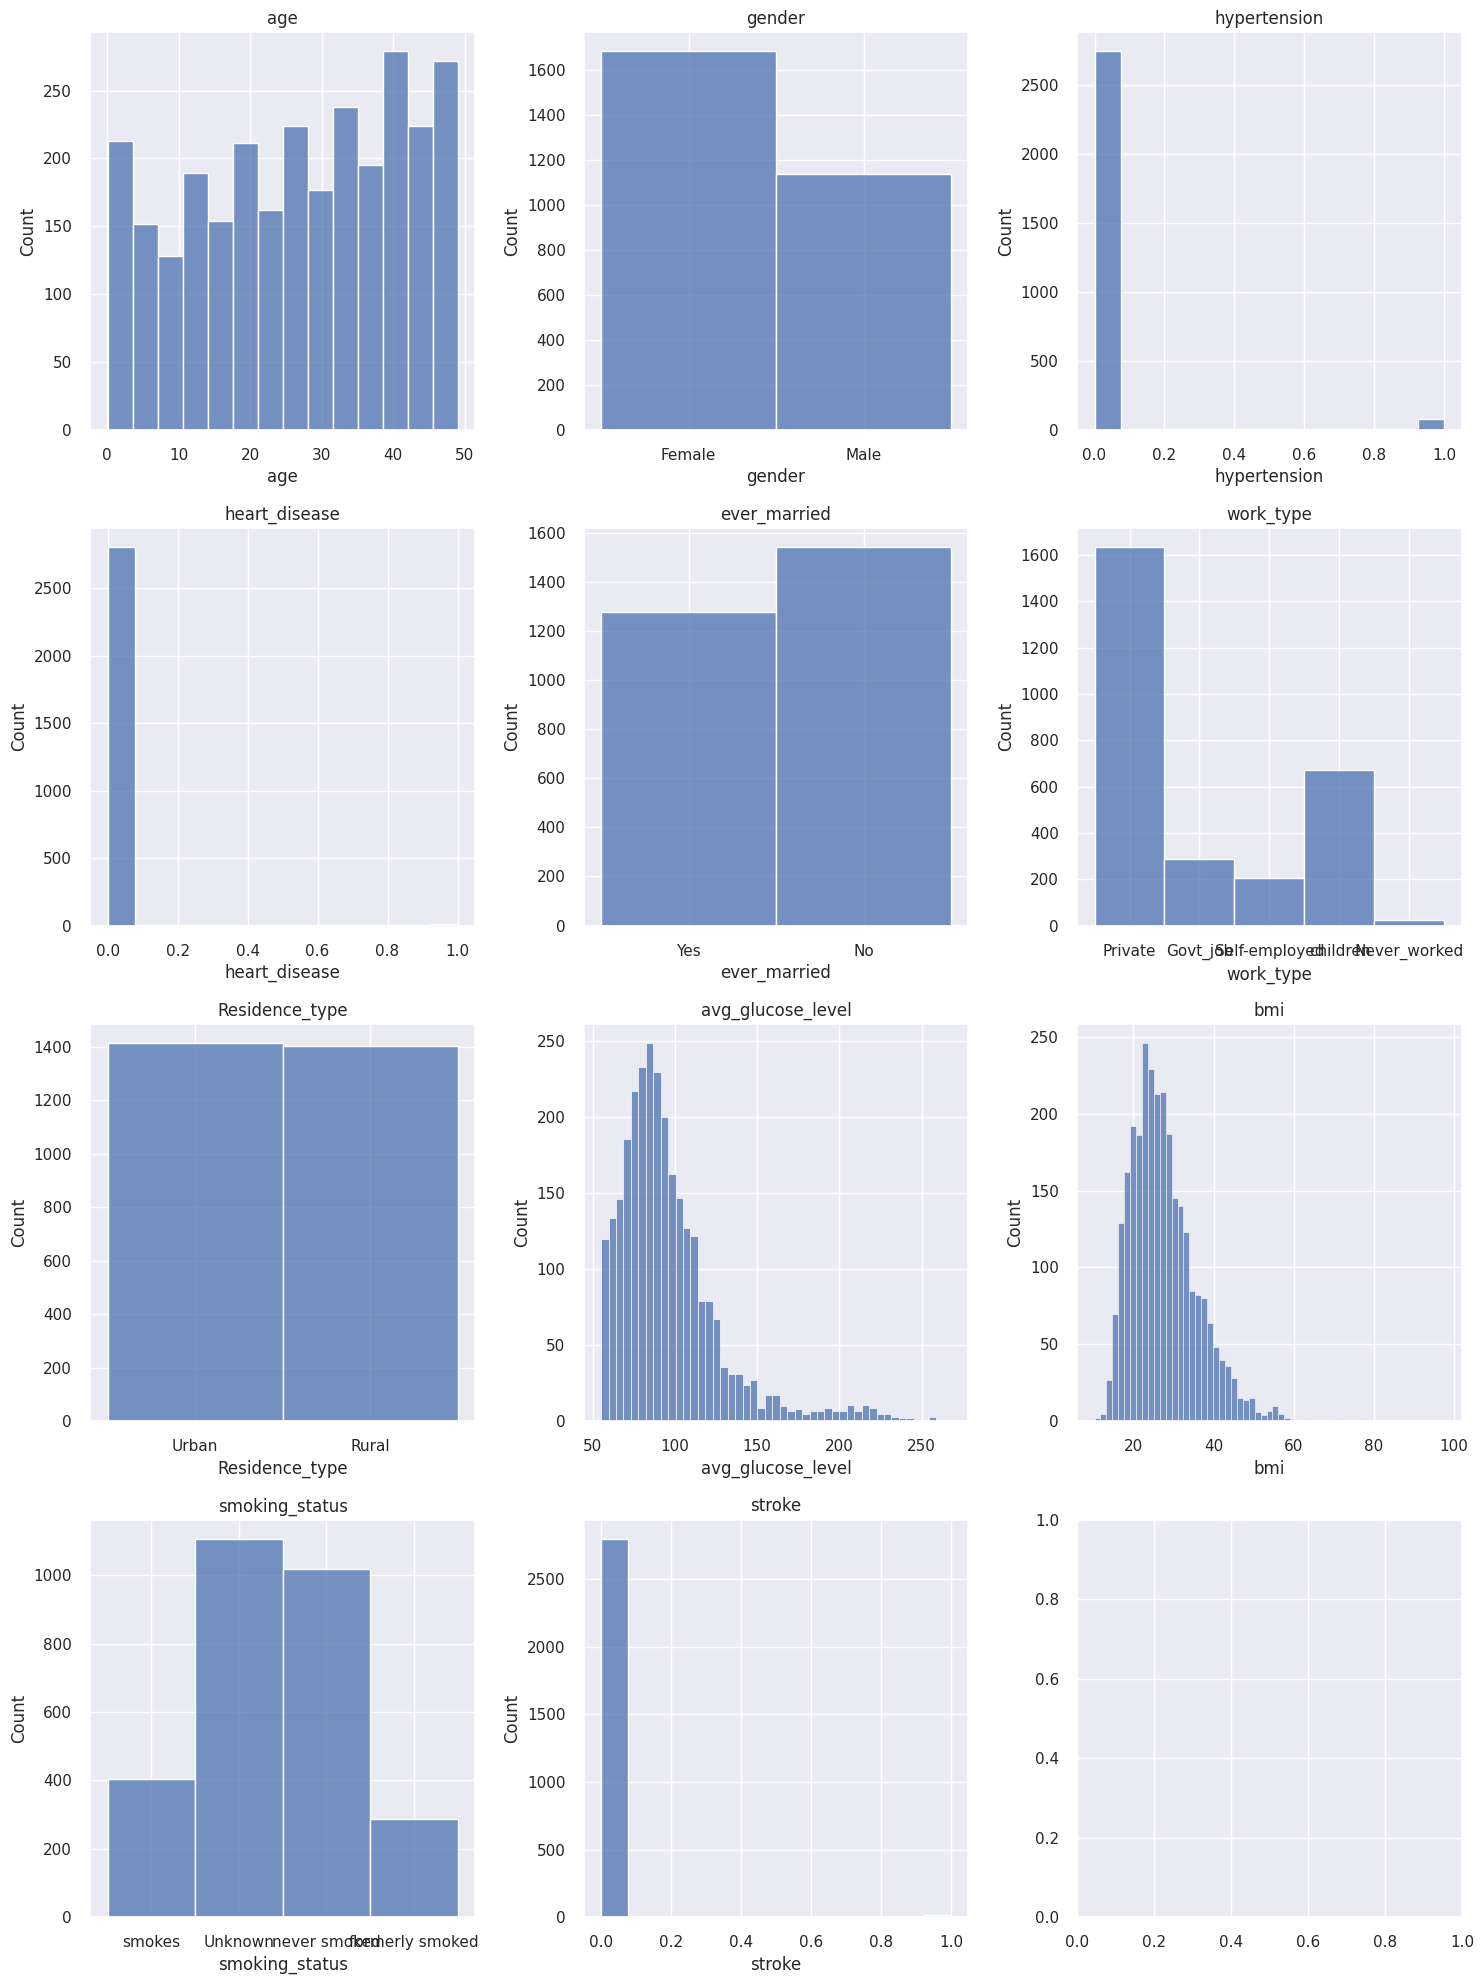

In [8]:
fig, axes = plt.subplots(4,3,figsize=(15,20))

for i, c in enumerate(data.columns):
    ax = axes.reshape(-1)[i]
    if data[c].dtype.kind == "object":
        a = sns.countplot(x=c,data=data,ax=ax)
    else:
        b = sns.histplot(x=c,data=data,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

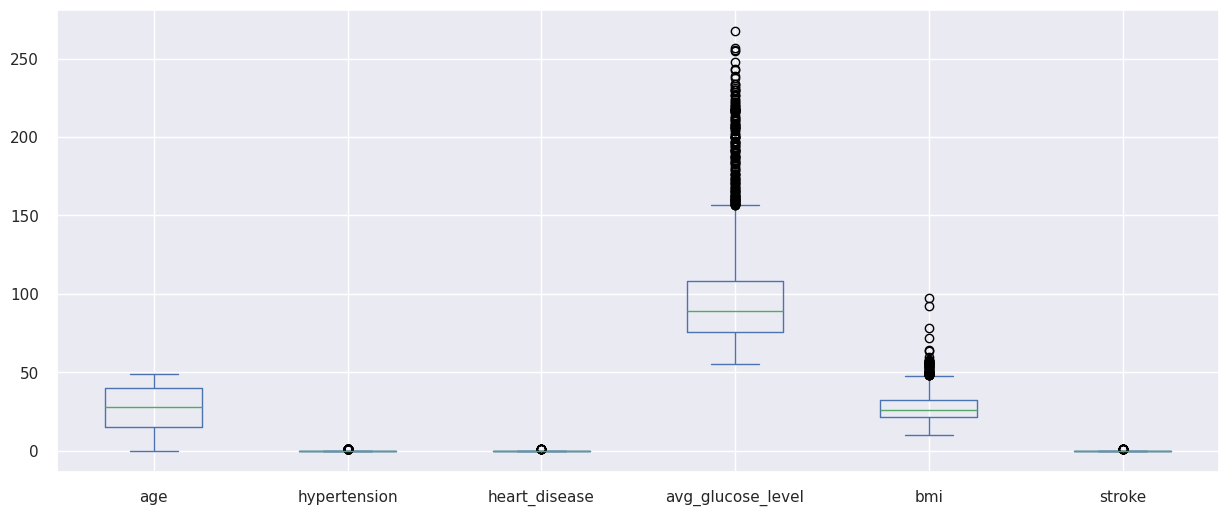

In [9]:
data.plot.box(figsize=(15,6));

Vamos a visualizar la correlación entre variables usando un heatmap.

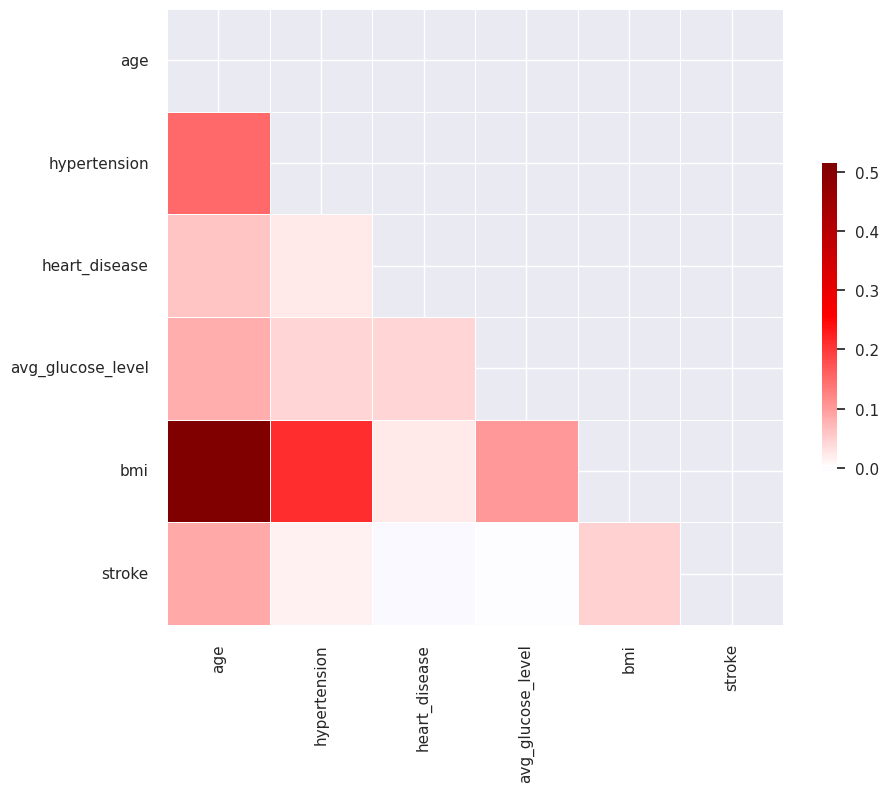

In [10]:
corr = data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

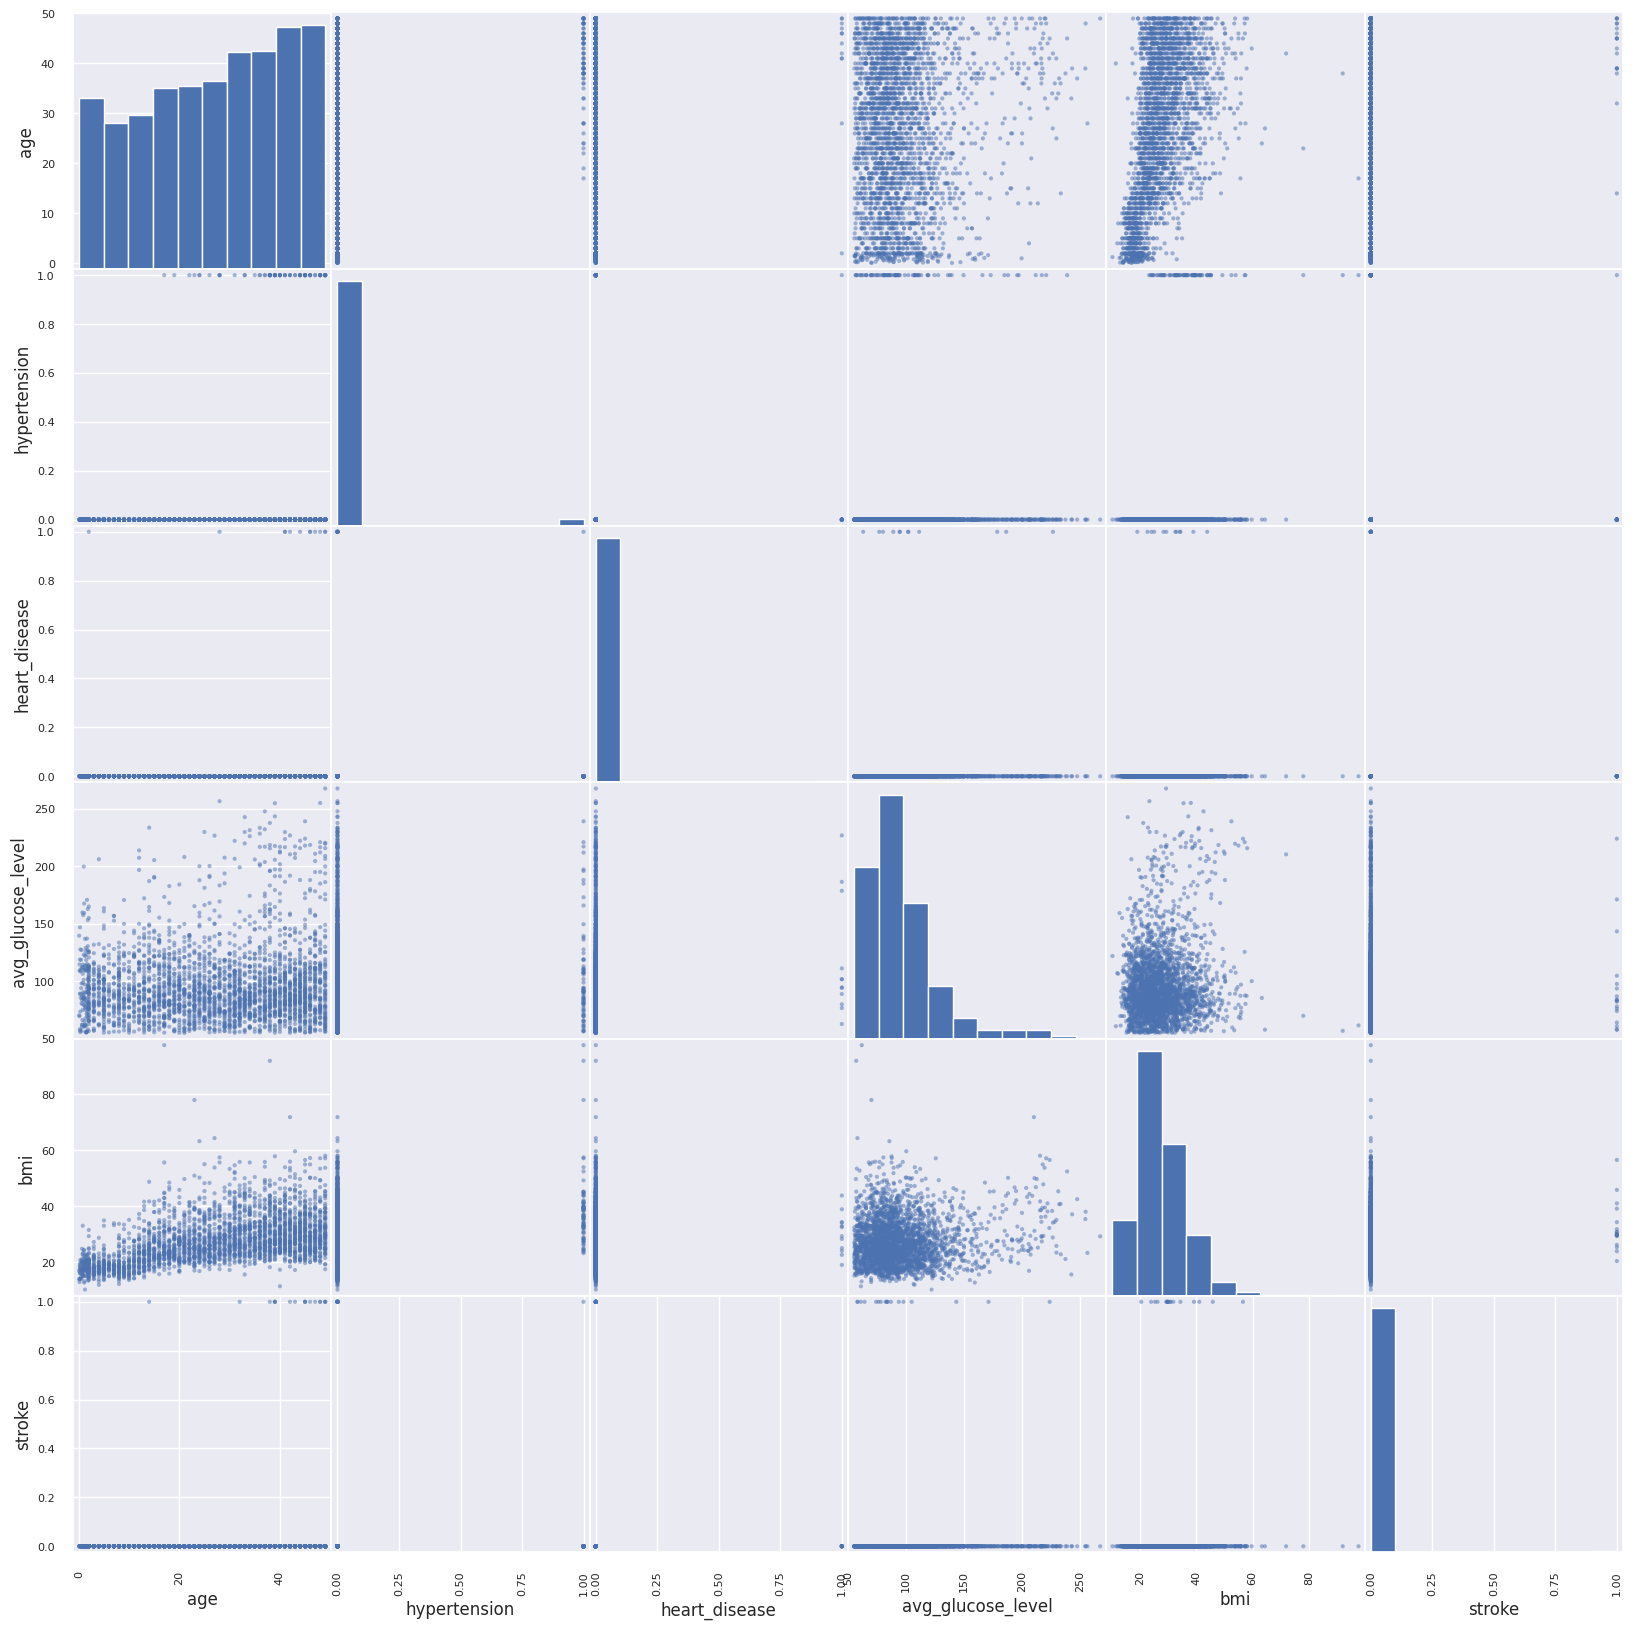

In [11]:
pd.plotting.scatter_matrix(data, figsize=(20,20));

In [12]:
data.isna().sum().sort_values(ascending=False)

age                  0
gender               0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [13]:
data["smoking_status"].value_counts(), data.shape

(smoking_status
 Unknown            1107
 never smoked       1019
 smokes              405
 formerly smoked     287
 Name: count, dtype: int64,
 (2818, 11))

Algunas observaciones sobre los datos:
- Vemos que solamente tenemos ejemplos de personas entre 0 y 50 años, aproximadamente. Si las caracteristicas de los mayores de 50 años no escalan linearmente respecto a las caracteristicas de los menores de 50, es posible que el modelo de regresión no sea demasiado bueno para predecir las edades de los mayores de 50.
- Tenemos bastantes variables categóricas, como por ejemplo smoking_status o resident_type, que tendremos que convertir a variables discretas.
- Tenemos missing values codificados como "Unknown" en el atributo smoking_status. En concreto, son 1107 ejemplos los que tienen este valor, sobre el total de 2818 ejemplos que tenemos.
- Todos los atributos estan correlacionados positivamente con el atributo age, en mayor o menor medida. bmi tiene la correlación más fuerte con el atributo age.
- Los casos de stroke, heart_disease y hypertension son mucho más comunes entre los mayores de 25-30 años, siendo casi inexistentes entre los menores de 20.

### Análisis de los valores faltantes

Como se ha mencionado en el apartado de observación, existen valores faltantes para la variable smoking_status. Estos valores se han codificado con "Unknown". En la información del dataset (ver https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), se explica que "Unknown" significa que la información no está disponible para ese paciente. En otras palabras, que es un valor faltante. Hacer un one-hot encoding sobre la este atributo sin excluir "Unknown" sería incorrecto. A continuación, se buscará la manera más adecuada de solucionar este problema. Tenemos varias opciones:
- Eliminar todos los ejemplos en los que smoking_status sea "Unknown". Como se ha señalado en el apartado de observación, 1107 ejemplos del total de 2818 serían eliminados. Estaríamos eliminando el 40% de los ejemplos, aproximadamente.
- Eliminar la variable smoking_status.
- Imputar los valores faltantes.


Vamos a analizar como se relaciona el atributo smoking_status con el resto de atributos no objetivo. Esto nos servirá para decidir qué hacer con los valores faltantes en esta variable.

smoking_status
Unknown            620
never smoked        86
formerly smoked     18
smokes               3
Name: count, dtype: int64
smoking_status
Unknown    459
Name: count, dtype: int64


Text(0, 0.5, 'Nº Ejemplos con smoking_status=Unknown')

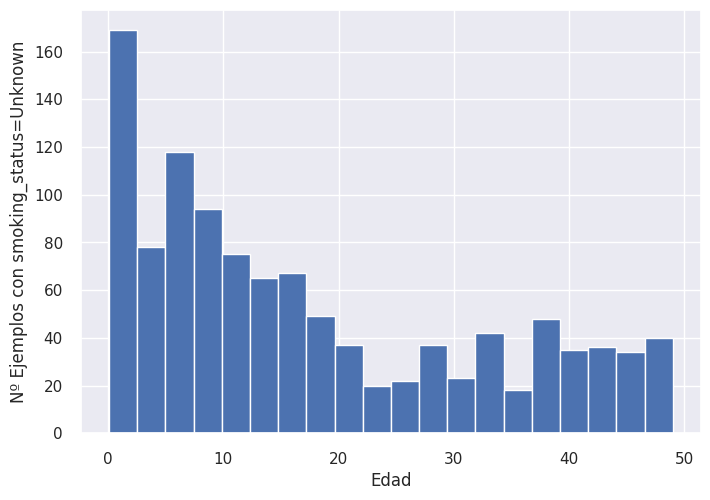

In [14]:
print(data.loc[data["age"] < 16, "smoking_status"].value_counts())

print(data.loc[data["age"] < 10, "smoking_status"].value_counts())

plt.hist(data.loc[data["smoking_status"] == "Unknown"]["age"], bins=20)
plt.xlabel("Edad")
plt.ylabel("Nº Ejemplos con smoking_status=Unknown")

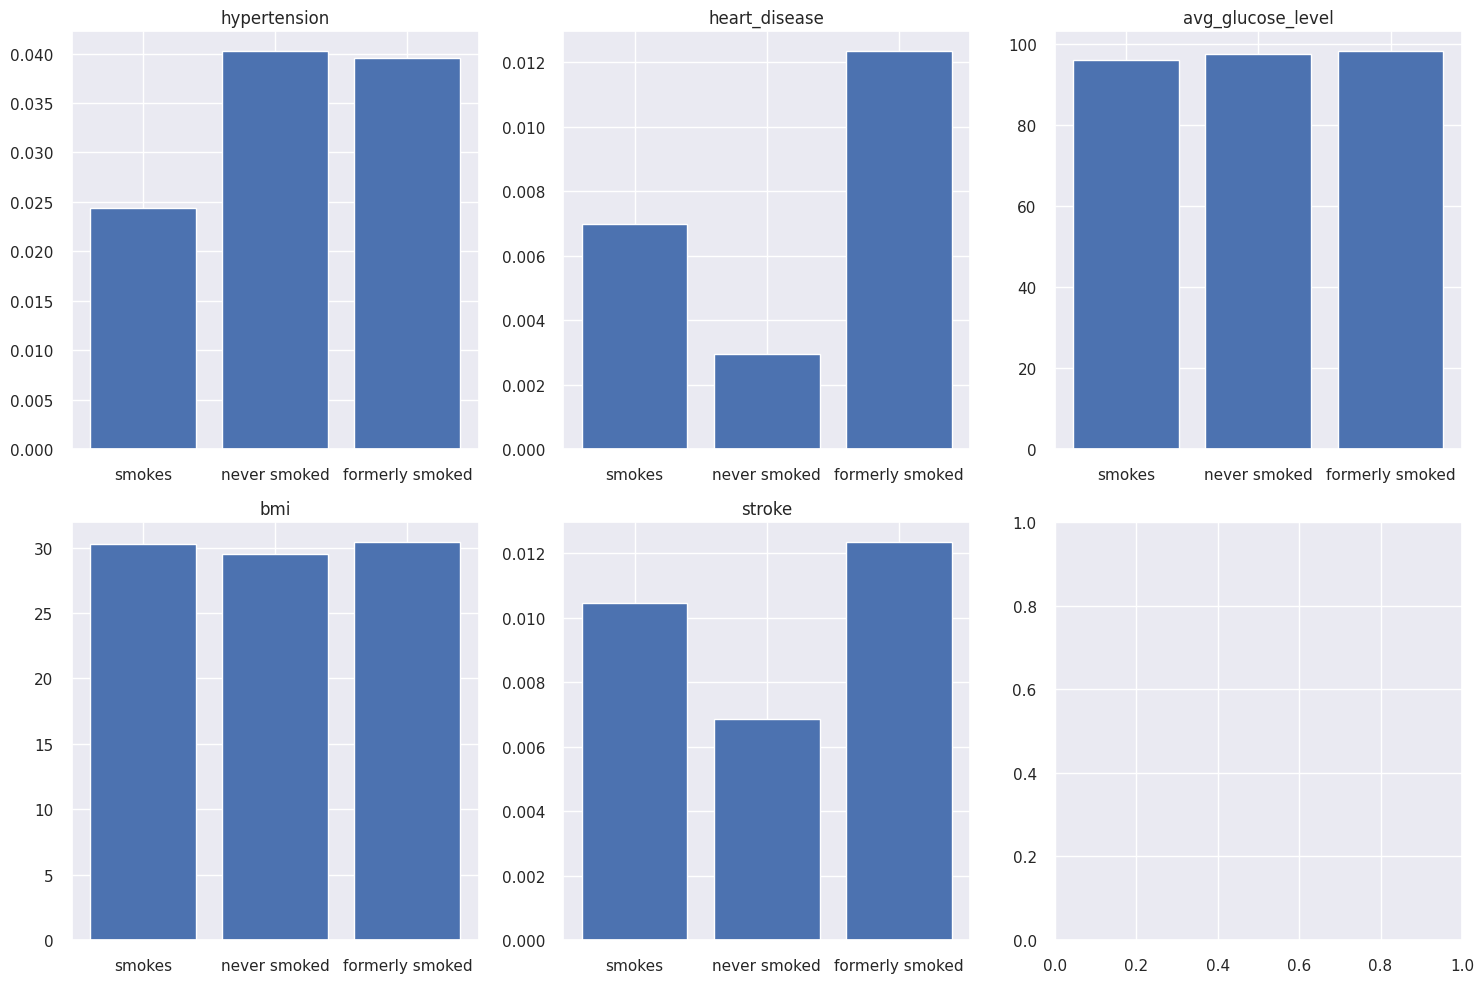

In [15]:
data_smokes = data.drop(index=data.loc[data["smoking_status"] == "Unknown", :].index)

fig, axes = plt.subplots(2,3,figsize=(15,10))

for i, c in enumerate(data_smokes.drop(columns=["age"]).select_dtypes(exclude="O").columns):
    ax = axes.reshape(-1)[i]
    if data_smokes[c].dtype.kind != "O":
        ax.bar(data_smokes['smoking_status'].unique(), data_smokes.groupby('smoking_status')[c].mean())
    t = ax.set_title(c)
plt.tight_layout()

<BarContainer object of 727 artists>

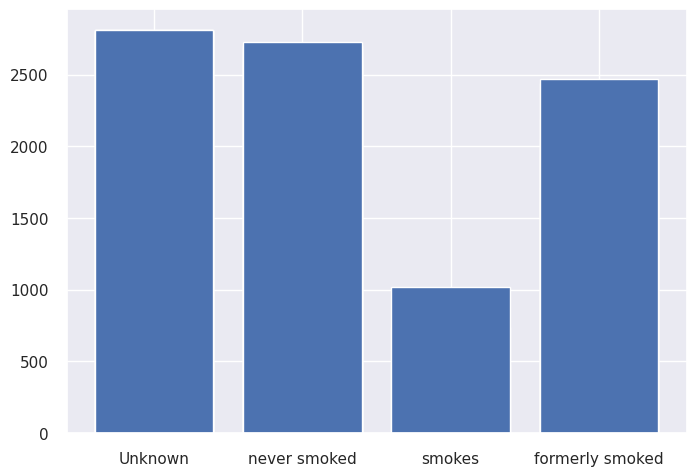

In [16]:
data_under16 = data.loc[data["age"] < 16, :]

plt.bar(data_under16["smoking_status"].values, data_under16["smoking_status"].index)

Podemos observar que:
- Más del 50% de ejemplos que tienen valor "Unknown" en el atributo smoking_status son menores de 16 años. Todos los niños menores de 10 años (459 niños en total) tienen valor "Unknown". 
- Las enfermedades cardiovasculares (heart_disease) son más comunes entre aquellos que fuman o han fumado alguna vez que entre aquellos que nunca han fumado. Este comportamiento también se puede observar en la variable stroke, y en la variable hypertension, si agrupamos aquellos que fuman o que han fumado y los comparamos con aquellos que no fuman.

Es cierto que incluir smoking_status, al estar correlacionado con otras variables, puede hacer que sea más difícil determinar los efectos independientes de las otras variables sobre la edad. Pero, por otro lado, smoking_status puede afectar las características médicas de una muestra. Por ejemplo, es posible que una persona de 40 años que ha fumado desde los 18 tenga características médicas parecidas a las de una persona de 50 años que no ha fumado nunca. Por este motivo, en vez de eliminar la variable del dataset, imputaremos los valores faltantes.

### Partición en datos de entrenamiento y test

Separamos la variable objetivo del resto de los atributos y hacemos un split del 70/30%.

In [17]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4096)

### Preprocesamiento de los datos

Los modelos de regresión que vamos a utilizar no aceptan ni valores faltantes ni variables categoricas. Vamos a hacer un preprocesamiento que solucione estos dos problemas y que normalize los valores.

Primero vamos a decidir cómo imputaremos los valores faltantes de smoking_status. Ahora trabajamos con la partición de entrenamiento, ya que de lo contrario estaríamos sesgando los datos.

In [18]:
# Cambiamos los valores smoking_status="Unknown" por NaN, para que el KNN los reconozca.

X_train_copy = X_train

#X_train_copy["smoking_status"] = X_train_copy["smoking_status"].replace("Unknown", np.nan)

#X_train_copy["smoking_status"].value_counts(dropna=False)

In [19]:
categoricals = ["gender","work_type","Residence_type","smoking_status"]

for var in categoricals:
    X_train_copy[var] = X_train_copy[var].astype("category")
    

In [20]:
X_train_copy["gender"] = X_train_copy["gender"].cat.codes
X_train_copy["Residence_type"] = X_train_copy["Residence_type"].cat.codes

In [21]:
dummies = pd.get_dummies(X_train_copy["work_type"], drop_first=True, prefix="work_type", prefix_sep='_')
X_train_copy = pd.concat([X_train_copy,dummies], axis=1)
X_train_copy.drop(columns=["work_type"], inplace=True)

In [22]:
mapdict_ever_married = {"No" : 0, "Yes" : 1}

X_train_copy["ever_married"] = X_train_copy["ever_married"].map(mapdict_ever_married)

In [23]:
mapdict_smoking_status = {"never smoked" : 0, "formerly smoked" : 1, "smokes" : 2, "Unknown" : np.nan}

X_train_copy["smoking_status"] = X_train_copy["smoking_status"].map(mapdict_smoking_status)

In [24]:
imputer = KNNImputer(n_neighbors=2)

imputer.fit(X_train_copy)

X_train_copy_imputed = X_train_copy

X_train_copy_imputed["smoking_status"] = imputer.transform(X_train_copy)[:, 7]

X_train_copy_imputed["smoking_status"] = X_train_copy_imputed["smoking_status"].map(round)

In [25]:
inv_mapdict_smoking_status = dict(zip(mapdict_smoking_status.values(), mapdict_smoking_status.keys()))

inv_mapdict_smoking_status

{0: 'never smoked', 1: 'formerly smoked', 2: 'smokes', nan: 'Unknown'}

In [26]:
X_train_copy_imputed["smoking_status"] = X_train_copy["smoking_status"].map(inv_mapdict_smoking_status)

X_train_copy_imputed["smoking_status"].value_counts()

smoking_status
never smoked       1180
formerly smoked     427
smokes              365
Name: count, dtype: int64

In [27]:
X_train_copy_imputed = pd.concat([y_train, X_train_copy_imputed], axis=1)

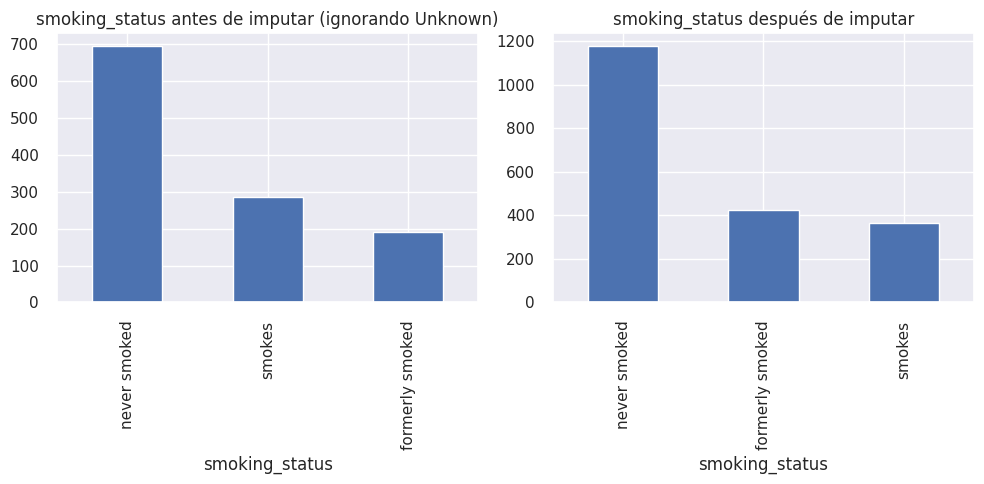

In [28]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

X_train["smoking_status"].value_counts().drop("Unknown").plot.bar(ax=axes[0], y=1200)
axes[0].set_title("smoking_status antes de imputar (ignorando Unknown)")
X_train_copy_imputed["smoking_status"].value_counts().plot.bar(ax=axes[1])
plt.title("smoking_status después de imputar")

plt.tight_layout()

In [29]:
X_train_copy_imputed.loc[X_train_copy_imputed["age"] < 10, "smoking_status"].value_counts()

smoking_status
never smoked       224
formerly smoked     84
smokes              24
Name: count, dtype: int64

Vemos que imputando los valores mediante KNN la distribución se mantiene bastante bien en el conjunto de edades. Para las edades de menores de 10 años, nos da una mayoría de casos de "never smoked".

Utilizaremos entonces KNN para imputar los valores, con los parámetros que hemos decido más arriba.

In [30]:
def preprocesado(X, y, scaler=None, normalize=True):
    # Cambiamos el tipo de los atributos categóricos.
    categoricals = ["gender","work_type","Residence_type","smoking_status"]
    for var in categoricals:
        X[var] = X[var].astype("category")
        
    # Convertimos atributos binarios a 0 o 1.
    X["gender"] = X["gender"].cat.codes
    X["Residence_type"] = X["Residence_type"].cat.codes
    
    # Convertimos atributos categóricos mediante One Hot Encoding
    dummies = pd.get_dummies(X["work_type"], drop_first=True, prefix="work_type", prefix_sep='_')
    X = pd.concat([X,dummies], axis=1)
    X.drop(columns=["work_type"], inplace=True)
    
    mapdict_ever_married = {"No" : 0, "Yes" : 1}
    X["ever_married"] = X["ever_married"].map(mapdict_ever_married)
    
    mapdict_smoking_status = {"never smoked" : 0, "formerly smoked" : 1, "smokes" : 2, "Unknown" : np.nan}
    X["smoking_status"] = X["smoking_status"].map(mapdict_smoking_status)
    
    # Imputamos valores faltantes de smoking_status usando KNN.
    imputer = KNNImputer(n_neighbors=2)
    imputer.fit(X)

    X["smoking_status"] = imputer.transform(X)[:, 7]
    X["smoking_status"] = X["smoking_status"].map(round)
    
    # Test
    #X.loc[y < 10, "smoking_status"] = "never smoked"
    
    inv_mapdict_smoking_status = dict(zip(mapdict_smoking_status.values(), mapdict_smoking_status.keys()))
    X["smoking_status"] = X["smoking_status"].map(inv_mapdict_smoking_status)
    
    
    # Convertimos valores categóricos de smoking_status con One Hot Encoding
    dummies = pd.get_dummies(X["smoking_status"], drop_first=True, prefix="smoking_status", prefix_sep='_')
    X = pd.concat([X,dummies], axis=1)
    X.drop(columns=["smoking_status"], inplace=True)
    
    # Normalizamos
    numerical_cols = ["avg_glucose_level", "bmi"]
    
    if normalize:
        if scaler is None:
            scaler = MinMaxScaler()
            X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
        else:
            X[numerical_cols] = scaler.transform(X[numerical_cols])
    
    # Esto es un safeguard por si eliminasemos alguna fila de X.
    y=y[X.index]
    
    
    return X, y, scaler
    

### Visualización mediante PCA

Vamos a hacer un análisis de los datos utilizando PCA. Primero, aplicaremos el StandardScaler de Sklearn sobre los datos preprocesados, ya que de lo contrario la visualización no será correcta.

In [31]:
X_processed, y_processed, _ = preprocesado(X_train, y_train, normalize=False)

X_scaled = StandardScaler().fit_transform(X_processed)
X_scaled = pd.DataFrame(X_scaled, columns = X_processed.columns)

X_scaled.describe(include="all").T

count       mean  std    min    25%    50%  \
gender                       1972.0 -1.171e-16  1.0 -0.824 -0.824 -0.824   
hypertension                 1972.0  4.684e-17  1.0 -0.161 -0.161 -0.161   
heart_disease                1972.0 -1.982e-17  1.0 -0.064 -0.064 -0.064   
ever_married                 1972.0  2.702e-18  1.0 -0.910 -0.910 -0.910   
Residence_type               1972.0  7.657e-17  1.0 -0.999 -0.999 -0.999   
avg_glucose_level            1972.0  2.450e-16  1.0 -1.294 -0.654 -0.229   
bmi                          1972.0  1.693e-16  1.0 -2.063 -0.734 -0.165   
stroke                       1972.0  7.206e-18  1.0 -0.078 -0.078 -0.078   
work_type_Never_worked       1972.0  0.000e+00  1.0 -0.071 -0.071 -0.071   
work_type_Private            1972.0 -9.458e-17  1.0 -1.164 -1.164  0.859   
work_type_Self-employed      1972.0  4.504e-17  1.0 -0.285 -0.285 -0.285   
work_type_children           1972.0  3.603e-18  1.0 -0.570 -0.570 -0.570   
smoking_status_never smoked  1972.0 -1.261e-17  1.0 -1.221 -1.221  0.819   
smoking_status_smokes        1972.0  6.846e-17  1.0 -0.477 -0.477 -0.477   

                               75%     max  
gender                       1.213   1.213  
hypertension                -0.161   6.200  
heart_disease               -0.064  15.668  
ever_married                 1.099   1.099  
Residence_type               1.001   1.001  
avg_glucose_level            0.379   5.502  
bmi                          0.535   6.042  
stroke                      -0.078  12.780  
work_type_Never_worked      -0.071  14.007  
work_type_Private            0.859   0.859  
work_type_Self-employed     -0.285   3.511  
work_type_children          -0.570   1.756  
smoking_status_never smoked  0.819   0.819  
smoking_status_smokes       -0.477   2.098

In [32]:
# Version age aparte
# X_processed, y_processed, _ = preprocesado(X_train, y_train, normalize=False)

# X_scaled = StandardScaler().fit_transform(X_processed)
# X_scaled = pd.DataFrame(X_scaled, columns = X_processed.columns)

# train_scaled = pd.concat([y_processed, X_scaled], axis=1)
# train_scaled.describe(include="all").T

In [33]:
myPCA = PCA().fit(X_scaled);

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.18123491 0.10751328 0.0938752  0.07582688 0.07318654 0.07219154
 0.07047966 0.07016333 0.0667532  0.06421807 0.04314874 0.0411309
 0.02922297 0.01105478]
[0.18123491 0.28874819 0.38262339 0.45845027 0.53163681 0.60382836
 0.67430801 0.74447135 0.81122454 0.87544261 0.91859135 0.95972225
 0.98894522 1.        ]


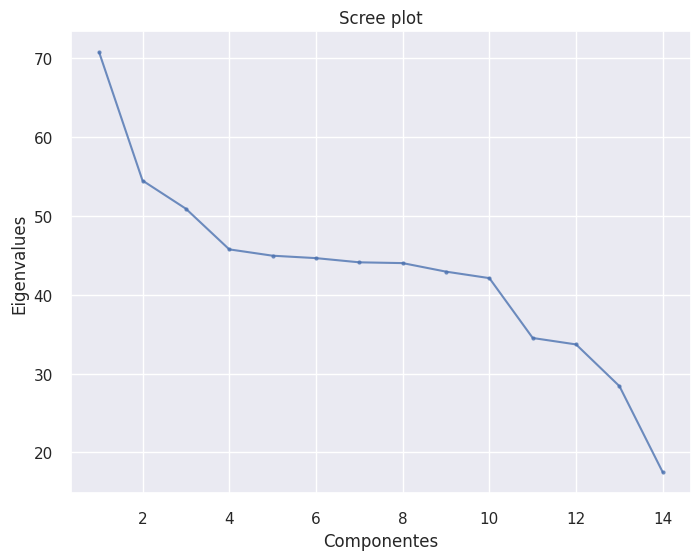

In [34]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
y_label = plt.ylabel('Eigenvalues');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

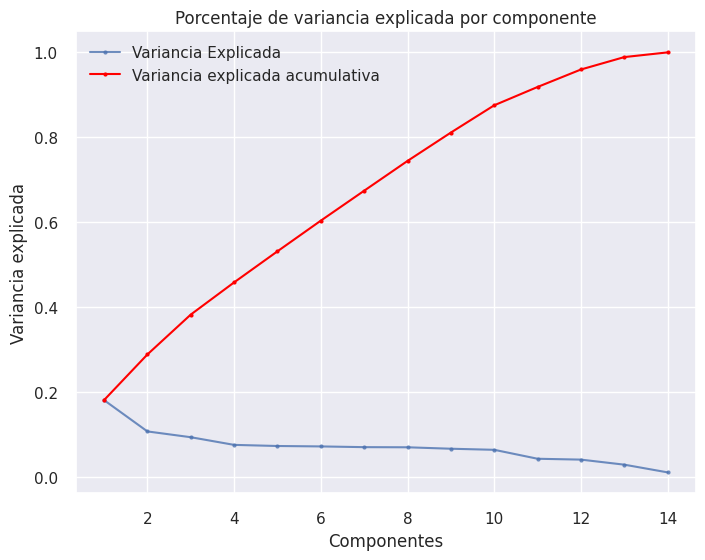

In [35]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

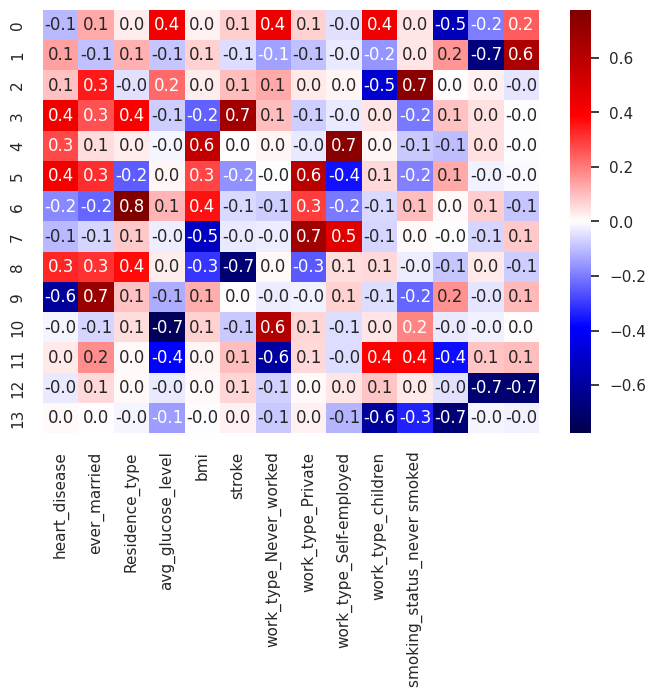

In [36]:
sns.heatmap(myPCA.components_, cmap='seismic', 
            xticklabels=list(X_scaled.columns[2:-1]),
            vmin=-np.max(np.abs(myPCA.components_)),
            vmax=np.max(np.abs(myPCA.components_)),
            annot=True, fmt=".1f");

In [37]:
transformed_train = myPCA.transform(X_scaled)
X_scaled[['PC1','PC2', 'PC3']] = transformed_train[:,:3]


In [38]:
X_scaled_copy = X_scaled.reset_index(drop=True)
y_train_copy = y_train.reset_index(drop=True)

X_scaled = pd.concat([X_scaled_copy, y_train_copy], axis=1)

X_scaled.isna().sum()

gender                         0
hypertension                   0
heart_disease                  0
ever_married                   0
Residence_type                 0
avg_glucose_level              0
bmi                            0
stroke                         0
work_type_Never_worked         0
work_type_Private              0
work_type_Self-employed        0
work_type_children             0
smoking_status_never smoked    0
smoking_status_smokes          0
PC1                            0
PC2                            0
PC3                            0
age                            0
dtype: int64

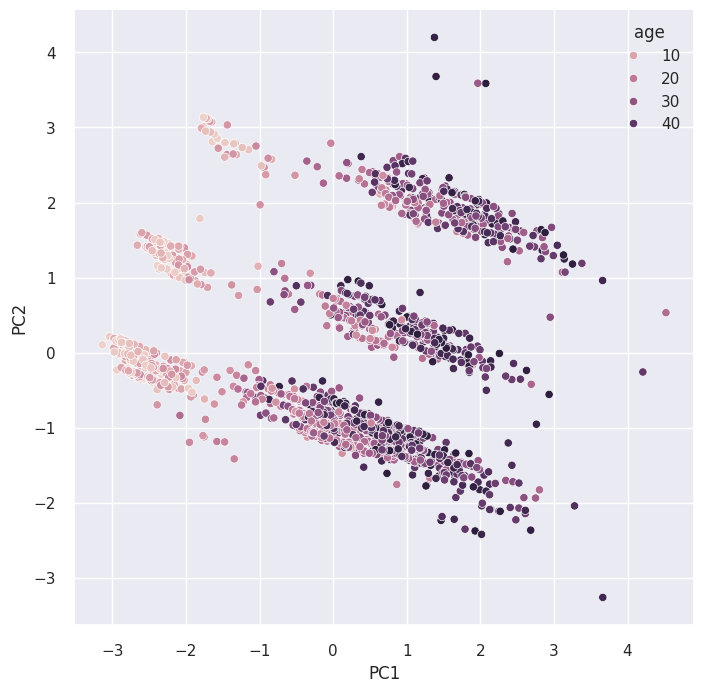

In [39]:
fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', hue="age", data=X_scaled)

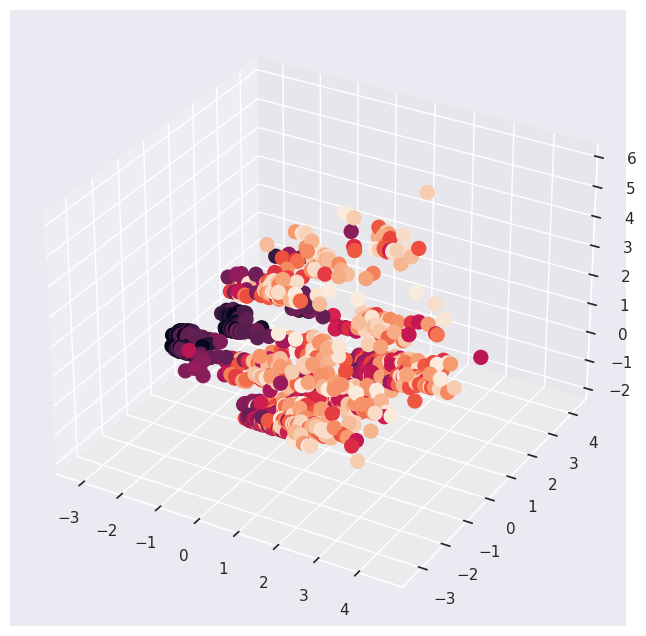

In [40]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(X_scaled.PC1,
            X_scaled.PC2,
            zs=X_scaled.PC3, 
            depthshade=False, 
            c=X_scaled['age'], s=100);

In [41]:
import plotly.express as px
fig = px.scatter_3d(X_scaled, x='PC1', y='PC2', z='PC3',
              color='age')
fig.show()

Después de la visualización en 2 dimensiones de los dos primeros componentes PC1 y PC2, podemos observar que:
- En primer lugar, los ejemplos se distribuyen según la edad, de izquierda a derecha. A la izquierda, tenemos los ejemplos de niños, y a medida que nos acercamos a la derecha, la edad va augmentando hasta llegar al máximo. Aunque en general, los ejemplos siguen este patrón, parece que va a ser difícil diferenciar exactamente ejemplos de edades próximas. Es posible que al modelo le sea difícil explicar la varianza entre, por ejemplo, una persona de 40 años y una persona de 45 años.
- En segundo lugar, los ejemplos se distribuyen en 3 grupos bien diferenciados. Es muy posible que estos tres grupos sean los no fumadores, fumadores ocasionales y fumadores.

Vamos a comprobar que, efectivamente, estos tres grupos sean los de smoking_status.

In [42]:
train_scaled_copy = X_scaled.reset_index(drop=True)
smoking_status = X_train["smoking_status"].reset_index(drop=True)
train_scaled_smoking_status = pd.concat([train_scaled_copy, smoking_status], axis=1)

In [43]:
def smoking_status_dummies_to_categorical(df):
    # smoking_status_never smoked smoking_status_smokes
    list = []
    for ind in df.index:
        
        if df["smoking_status_never smoked"][ind] == True:
            list.append("never smoked")
        elif df["smoking_status_smokes"][ind] == True:
            list.append("smokes")
        else:
            list.append("formerly smoked")
        
    return list
    

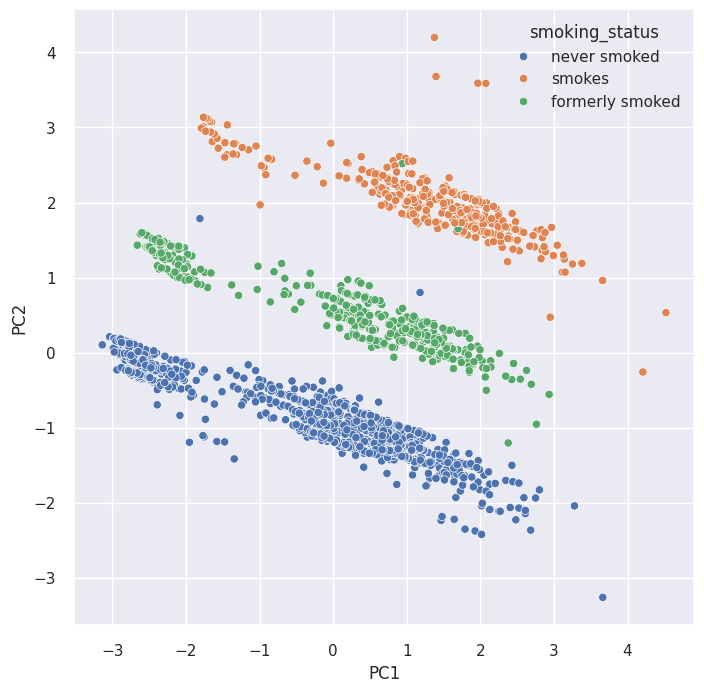

In [44]:
smoking_status_imputed_categorical = smoking_status_dummies_to_categorical(X_processed)
smoking_status_imputed_categorical = pd.DataFrame(smoking_status_imputed_categorical)

train_all = pd.concat([train_scaled_copy, smoking_status_imputed_categorical], axis=1)
train_all.rename(columns={0 : "smoking_status"}, inplace=True)

fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', hue="smoking_status", data=train_all)

En efecto, podemos ver como los ejemplos se distribuyen según su smoking_status. Cabe destacar que esta variable no es la variable objetivo, pero si el modelo aprende que hay tres grupos bien diferenciados según su smoking_status, podrá saber predecir mejor la edad de cada persona dependiendo del grupo en el que se encuentre y el resto de atributos servirán para decidir, dentro de ese grupo, dónde se sitúa.

### Ajuste de regresión LASSO

Vamos a ajustar un modelo de regresión LASSO para predecir la edad de las personas. Utilizaremos validación cruzada para estimar la calidad de la regresión.

In [45]:
X_train_processed, y_train_processed, scaler = preprocesado(X_train, y_train, normalize=True)

In [46]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]


lasso_cv = LassoCV(alphas=lambdas,cv=5).fit(X_train_processed,y_train_processed)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train_processed,y_train_processed))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 0.001 R2 score: 0.7826307139095476


Tenemos un R squared de 0.78 en los datos de entrenamiento. Esto significa que nuestro modelo explica un 78% de la variancia en la variable objetivo. Este resultado es el esperado. Como hemos visto en el PCA, aunque los ejemplos se distribuyen, en general, de menor a mayor edad, es difícil modelar la variancia entre dos ejemplos que estén bastante juntos. Además, aunque, a grandes rasgos, muchos de los atributos sí que escalan con la edad (por ejemplo, heart_disease o bmi), la diferencia de los atributos entre dos ejemplos de edad parecida puede no seguir ningún patrón.

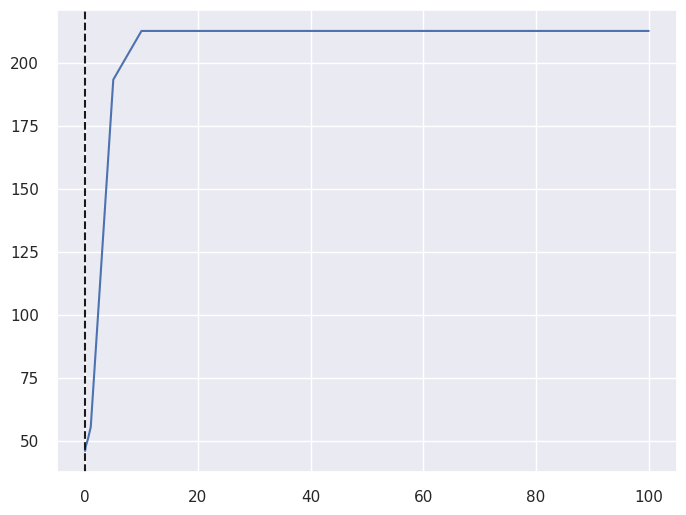

In [47]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train_processed, y_train_processed);

In [48]:
X_test_processed, y_test, _ = preprocesado(X_test, y_test, scaler)

r2_score(y_test,lasso_cv.predict(X_test_processed))

0.7389979798964554

Utilizando el modelo para hacer predicciones con los datos de test, nos da un R2 de 73.9%. Es unos 4 puntos inferior al R2 de entrenamiento. Al no ser la diferencia muy grande, podemos ver que no hay mucho sobreajuste sobre los datos de entrenamiento.

Vamos a ver que pesos ha asignado el LASSO a cada variable.

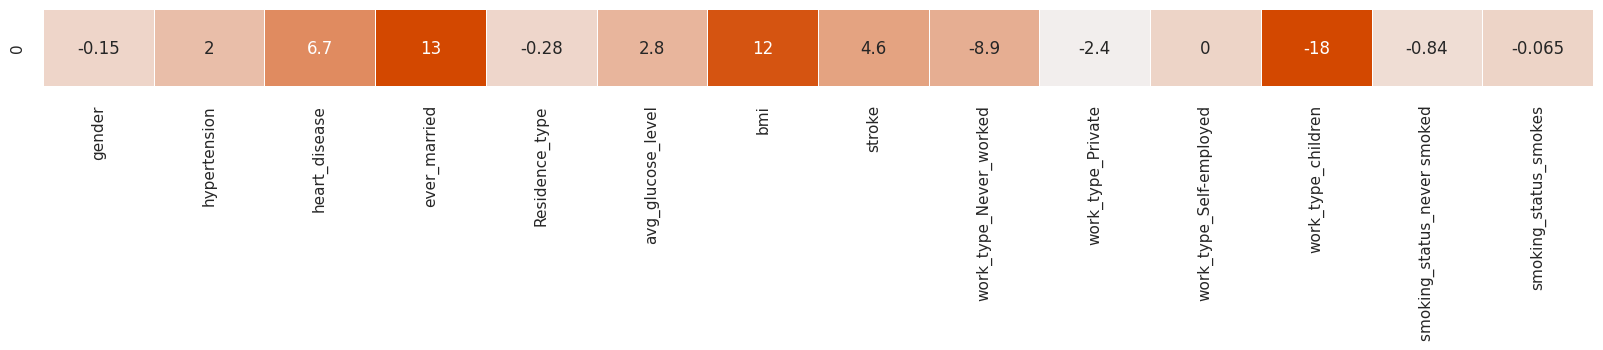

In [49]:
weights = pd.DataFrame(lasso_cv.coef_, index=X_train_processed.columns)
cmap = sns.diverging_palette(20, 20, as_cmap=True, s=100, l=50)
plt.figure(figsize = (20,1));
sns.heatmap(weights.T,annot=True, linewidths=.5,cbar=False,xticklabels=True, cmap=cmap);

Vemos que nuestro modelo ha asignado los pesos mayores a work_type_children, seguido de ever_married y de bmi. Vemos  que tiene sentido que los dos primeros tengan estos pesos tan altos, al estar muy fuertemente relacionados con la variable objetivo. Es lógico pensar que si alguien cae en la categoría de work_type_children, tendrán menos de 16 años; también que si la persona se ha casado (ever_married), tendrá más de 18, como mínimo. Otros atributos que también tienen un peso significante son:
- bmi: Como se ha observado en el apartado de visualización, este atributo está bastante correlacionado con age.
- work_type_never_Worked: Los motivos por los que el modelo ha dado un peso alto a este atributo son parecidos a los de work_type_children, en el sentido que la gran mayoría de ejemplos donde este atributo sea 1, la edad será menor a 18 años. A medida que la edad augmenta, es menor probable que nunca hayan trabajado.
- heart_disease y stroke: Tal como hemos visto en la visualización de los datos, estos dos atributos estan positivamente correlacionados con la edad.

Si quisieramos obtener mejores resultados, muy posiblemente tendríamos que recurrir a un modelo más complejo. Los modelos de regresión lineal funcionan muy bien si los datos escalan linealmente respecto a la variable objetivo, pero al haber tanta variancia en los atributos de ejemplos de personas de la misma edad o de edades parecidas, al modelo le cuesta precedir con precisión las edades.

### Residuos de la regresión y comparación de predicciones



Finalmente, vamos comparar las predicciones que ha hecho nuestro modelo con los valores reales. También representaremos los residuos de la regresión LASSO, y veremos qué distribución siguen.

In [50]:
edad_real = y_test

edad_prediccion = lasso_cv.predict(X_test_processed)

df = pd.DataFrame({'edad_real': edad_real, 'edad_prediccion': edad_prediccion})

df.head(30)

edad_real  edad_prediccion
838       41.00           40.720
2801      34.00           37.328
1383      15.00            8.105
236       42.00           40.489
1380      46.00           42.756
1007      38.00           37.215
132       42.00           39.165
2262      43.00           39.574
268       45.00           36.820
1216       7.00            6.507
52        27.00           35.901
1399      45.00           25.924
540       32.00           39.710
465       22.00           25.021
1119      40.00           33.711
1059      42.00           39.846
120       43.00           37.541
1194      31.00           38.099
1323      13.00            6.830
1754      23.00           26.870
2396      38.00           36.328
1623      39.00           39.031
1332      28.00           37.079
1993      36.00           24.262
1159      43.00           27.482
216       46.00           43.009
2409      40.00           38.857
777       17.00           26.123
1206      14.00           17.234
1281       1.64            7.018

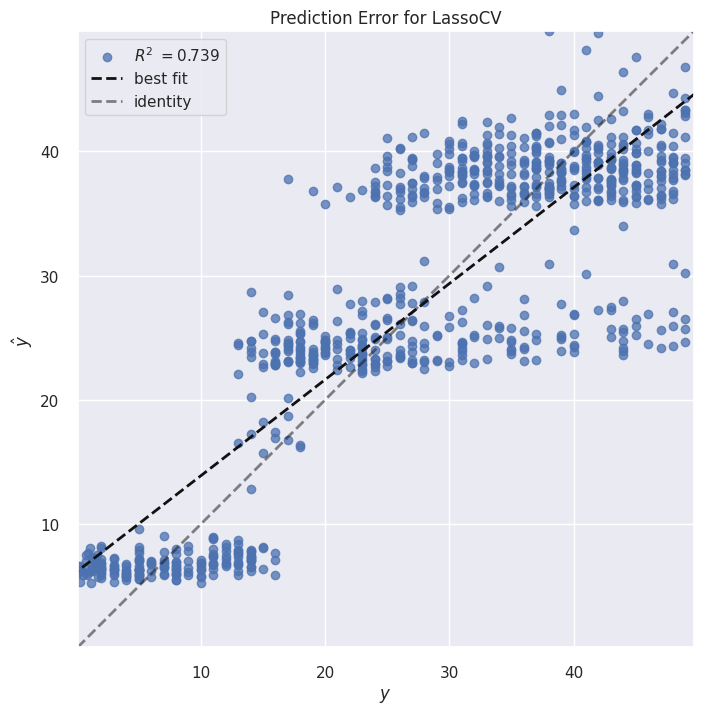

In [51]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(lasso_cv, X_test_processed, y_test, is_fitted=True)

Podemos observar que nuestro modelo, en general, tiende a sobreestimar las edades de los niños. Lo contrario pasa con los más adultos: el modelo tiende a subestimar sus edades.

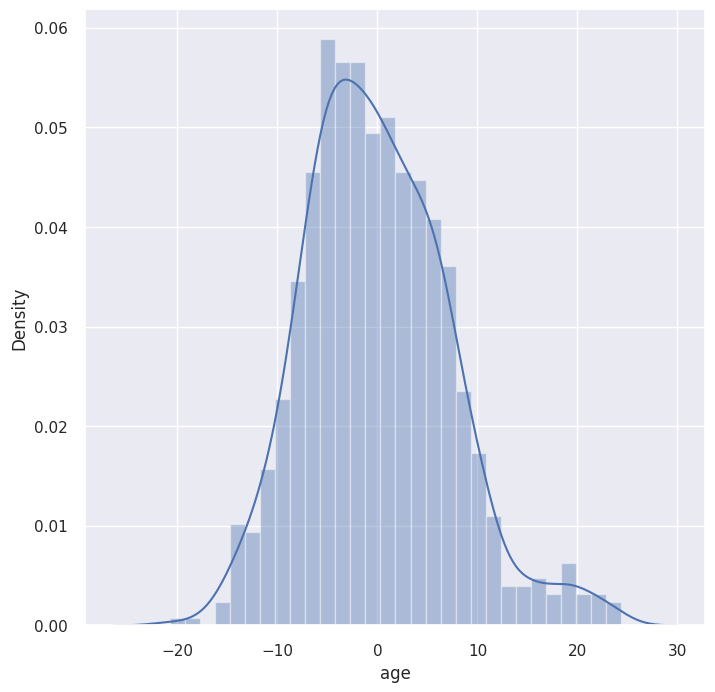

In [52]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(edad_real-edad_prediccion,bins=30);

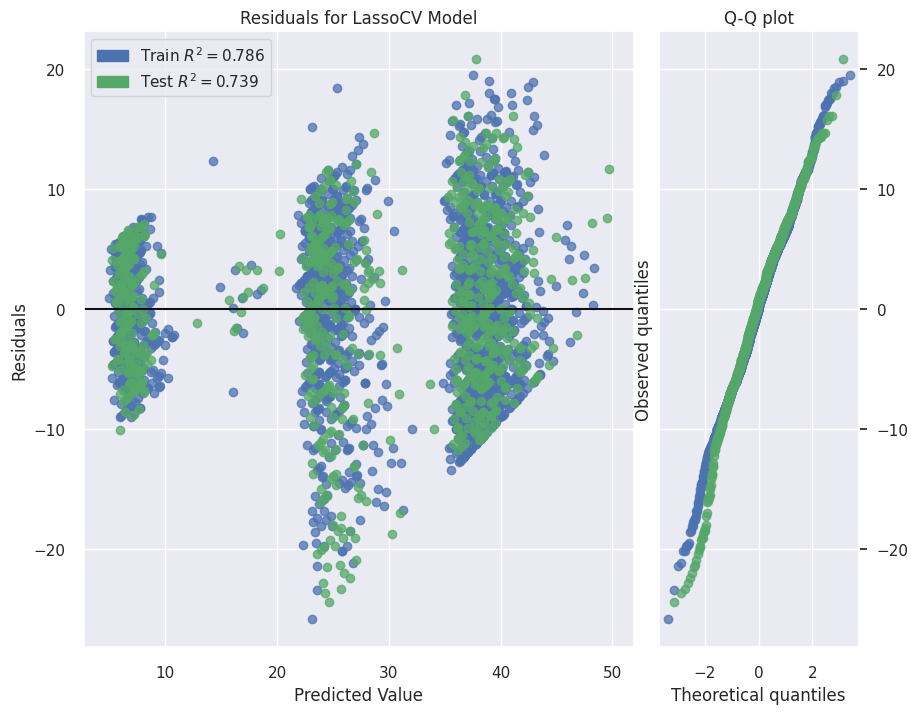

In [53]:
plt.figure(figsize=(10,8));
viz = residuals_plot(lasso_cv, X_train_processed, y_train_processed, X_test_processed, y_test, is_fitted=True, qqplot=True, hist=False);

Como se puede observar en el Q-Q plot, la distribución de los residuos es bastante parecida a una distribución normal. Cabe recordar que este era uno de los prerrequisitos del regresor LASSO: tener un ruido gaussiano.

In [54]:
mae = mean_absolute_error(edad_real,edad_prediccion)
mse = mean_squared_error(edad_real,edad_prediccion)
r_squared = r2_score(edad_real,edad_prediccion)

results = pd.DataFrame({"R2" : [r_squared], "MSE": [mse], "MAE" : [mae]})
results.index = ["Test results"]
results.T

Test results
R2          0.739
MSE        51.681
MAE         5.700

En la tabla de arriba se muestran los resultados del modelo para los datos de test. Tenemos un R2 del 73,9%, que significa que nuestro modelo explica un 73,9% de la variancia en los datos. Estos resultados son bastante buenos si tenemos en cuenta que, tal como se ha comentado anteriormente, al modelo le es muy difícil poder diferenciar las edades de vecinos cercanos. Esto se refleja en el error absoluto medio (MAE) de 5.7, que significa que la media del error absoluto de todas las predicciones que hemos hecho para los datos de test es de 5.7 años.

Es posible que un modelo más complejo pueda explicar la variancia que hay entre vecinos cercanos mejor que el LASSO o algún modelo de regresión similar.